# 1. 이해하기

## 1.1 전체 흐름

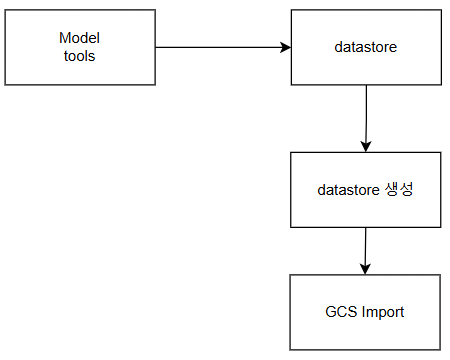

## 1.2 Import GCS

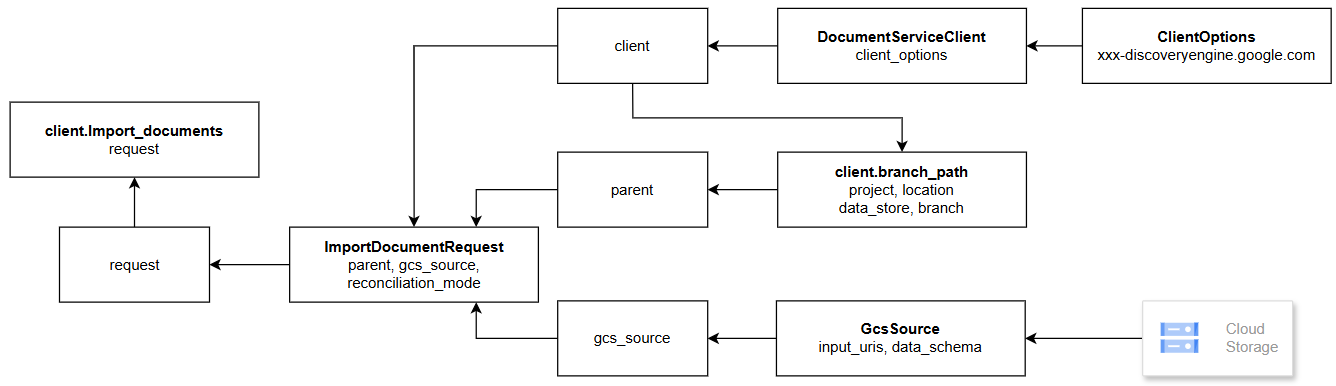

In [1]:
!pip install google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.4 MB/s eta 0:00:00


In [2]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.1.2 환경변수 설정

In [11]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID=PROJECT_ID[0]
LOCATION="global"
DATASTORE_ID="gcs_data_store2"

In [12]:
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine

In [21]:
def get_client(location, isDATASTORE):
  client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )

  # Create a client
  if isDATASTORE:
    return discoveryengine.DataStoreServiceClient(client_options=client_options)
  return discoveryengine.DocumentServiceClient(client_options=client_options)

In [16]:
def CreateDatastore(
    project_id: str,
    location: str,
    data_store_id: str,
    client
) -> str:
    # The full resource name of the collection
    # e.g. projects/{project}/locations/{location}/collections/default_collection
    parent = client.collection_path(
        project=project_id,
        location=location,
        collection="default_collection",
    )

    data_store = discoveryengine.DataStore(
        display_name=data_store_id,
        industry_vertical=discoveryengine.IndustryVertical.GENERIC,
        solution_types=[discoveryengine.SolutionType.SOLUTION_TYPE_SEARCH],
        content_config=discoveryengine.DataStore.ContentConfig.CONTENT_REQUIRED,
    )

    request = discoveryengine.CreateDataStoreRequest(
        parent=parent,
        data_store_id=data_store_id,
        data_store=data_store,
    )

    return client.create_data_store(request=request)

In [17]:
DATASTORE=True
client = get_client(LOCATION, DATASTORE)
operation = CreateDatastore(PROJECT_ID, LOCATION, DATASTORE_ID, client)


print(f"Waiting for operation to complete: {operation.operation.name}")
response = operation.result()

# Handle the response
print(response)


Waiting for operation to complete: projects/429718924597/locations/global/collections/default_collection/operations/create-data-store-3624907962513808989
name: "projects/429718924597/locations/global/collections/default_collection/dataStores/gcs_data_store2"
display_name: "gcs_data_store2"
industry_vertical: GENERIC
solution_types: SOLUTION_TYPE_SEARCH
default_schema_id: "default_schema"
content_config: CONTENT_REQUIRED
document_processing_config {
  name: "projects/429718924597/locations/global/collections/default_collection/dataStores/gcs_data_store2/documentProcessingConfig"
  default_parsing_config {
    digital_parsing_config {
    }
  }
}
serving_config_data_store {
}




In [60]:
def ImportToGCS(project_id, location, data_store_id, gcs_uri, client, reconciliation_mode):
  parent = client.branch_path(
      project=project_id,
      location=location,
      data_store=data_store_id,
      branch="default_branch",
  )
  gcs_source = discoveryengine.GcsSource(
          # Multiple URIs are supported
          input_uris=gcs_uri,
          # Options:
          # - `content` - Unstructured documents (PDF, HTML, DOC, TXT, PPTX)
          # - `custom` - Unstructured documents with custom JSONL metadata
          # - `document` - Structured documents in the discoveryengine.Document format.
          # - `csv` - Unstructured documents with CSV metadata
          data_schema="content",
      )
  request = discoveryengine.ImportDocumentsRequest(
      parent=parent,
      gcs_source=gcs_source,
      # Options: `FULL`, `INCREMENTAL`
      reconciliation_mode=reconciliation_mode,
  )

  return client.import_documents(request=request)

In [27]:
IMPORTDATA=False
reconciliation_mode = discoveryengine.ImportDocumentsRequest.ReconciliationMode.INCREMENTAL
gcs_uri=[
    # "gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/*.pdf",
    # "gs://cloud-samples-data/gen-app-builder/search/CUAD_v1/*.pdf",
    # "gs://cloud-samples-data/gen-app-builder/search/kaiser-health-surveys/*.pdf",
    "gs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/*.pdf"
]

client = get_client(LOCATION, IMPORTDATA)
operation = ImportToGCS(PROJECT_ID, LOCATION, DATASTORE_ID, gcs_uri, client, reconciliation_mode)

print(f"Waiting for operation to complete: {operation.operation.name}")
response = operation.result()

# After the operation is complete,
# get information from operation metadata
metadata = discoveryengine.ImportDocumentsMetadata(operation.metadata)

# Handle the response
print(response)
print(metadata)

Waiting for operation to complete: projects/429718924597/locations/global/collections/default_collection/dataStores/gcs_data_store2/branches/0/operations/import-documents-677881577713927114
error_samples {
  code: 9
  message: "Document projects/429718924597/locations/global/collections/default_collection/dataStores/gcs_data_store2/branches/0/documents/b61815749dc260094e7b1177af6096f6 (uri: gs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/backprop_old.pdf) is imported but failed to index. The error is: Failed to parse the document. The parsed result is empty. Please check your document and make sure it contains non-empty text content."
  details {
    type_url: "type.googleapis.com/google.rpc.ResourceInfo"
    value: "\022Qgs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/backprop_old.pdf:0"
  }
}
error_config {
  gcs_prefix: "gs://429718924597_us_import_content/errors677881577713928331"
}

create_time {
  seconds: 1736994547
  nanos: 457783000
}
update_time 

In [29]:
import vertexai

In [30]:
from vertexai.preview.generative_models import(
    GenerativeModel,
    GenerationConfig,
    Tool,
    grounding
)

In [31]:
def getModel(project_id, init_location, grounding_location, datastore_id, system_instruction):
  vertexai.init(project=project_id, location=init_location)

  tool = Tool.from_retrieval(
      grounding.Retrieval(
          grounding.VertexAISearch(
              datastore=datastore_id,
              project=project_id,
              location=grounding_location
          )
      )
  )

  return GenerativeModel(
      "gemini-1.5-flash",
      system_instruction=system_instruction,
      generation_config=GenerationConfig(temperature=0.0),
      tools=[tool])

In [56]:
system_instruction = """
- 목표
  grounding 안에서만 검색
- 출력 형식
  내용
    출력 결과
  참조 URI
    - gs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/*.pdf
"""

model = getModel(PROJECT_ID, "us-east1", LOCATION, DATASTORE_ID, system_instruction)

In [59]:
prompt="""
  인공지능 관련 학과에 대해 설명해줘?
"""

response = model.generate_content(prompt)
print(response.text)

## 내용
  인공지능 관련 학과는 컴퓨터 과학, 컴퓨터 공학, 인공지능, 데이터 과학 등 다양한 분야를 포함합니다. 스탠포드 대학교의 CS224n 과정은 자연어 처리에 중점을 둔 인공지능 관련 학과의 한 예시입니다. 이 과정은 딥 러닝을 자연어 처리에 적용하는 데 필요한 기본 지식을 다루며, 워드 벡터, 피드포워드 네트워크, 순환 신경망, 어텐션, 인코더-디코더 모델, 트랜스포머, 대규모 사전 훈련된 언어 모델 등을 포함합니다. 또한, 컴퓨터를 사용하여 인간 언어를 이해하고 생성하는 데 따른 어려움과 워드 의미, 의존성 분석, 기계 번역, 질의 응답 등 자연어 처리의 주요 문제에 대한 시스템 구축 방법을 다룹니다.

## 참조 URI
  - gs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/cs224n-2023-lecture01-wordvecs1.pdf
  - gs://cloud-samples-data/gen-app-builder/search/stanford-cs-224/Multimodal-Deep-Learning-CS224n-Kiela.pdf



* https://cloud.google.com/generative-ai-app-builder/docs/prepare-data?hl=ko#storage-unstructured
* https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es?hl=ko#storage-import-once